In [1]:
import glob
import cv2
from cv2 import drawContours
import os
import datetime
import pydot
os.environ['DISPLAY'] = ':1'
import numpy as np
from random import shuffle
from matplotlib import pyplot as plt
from PIL import Image
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import argparse
import imutils
from scipy import interpolate
import skimage
import skimage.morphology
from skimage.feature import canny
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
from matplotlib import cm
import pwlf

import segmentation_models as sm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.callbacks import TensorBoard
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.utils import normalize
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from skimage import data_dir,io,transform,color

Segmentation Models: using `keras` framework.


In [2]:
# If cv2.imshow() function dosen't work, use the followed line of code
os.environ['DISPLAY'] = ':1'

# Check if GPU is being used
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
##### Define a simple Unet, for further design customed neural network structure #####
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):

# Build the model, set the input as the image height, width and color channels
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Normalization of input data
    #s = Lambda(lambda x: x / 255)(inputs) 

    s = inputs

    # Encoder definition
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Decoder definition 
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    # Setting up optimizer, loss function and metrics
    #opt = tf.keras.optimizers.SGD(learning_rate=0.1)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['auccuracy'])

    #model.compile(optimizer='adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
    
    model.summary()
    
    return model

In [4]:
# Load the model
def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

#model = get_model()

In [5]:
##### Date import and process #####

# Define a images loading and padding function, with the input loading data 1200x1200 png images and output 1216x1216 png images
def load_and_padding_images(image_file_directory, channel):

    # Create a image list
    image_set = []

    # Check if the input folder exist
    if os.path.exists(image_file_directory)==False:
        raise FileNotFoundError( 'No such file or directory:'+ image_file_directory)
        
    # Reading the images in the folder 
    for directory_path in glob.glob(image_file_directory):
        img_path = glob.glob(os.path.join(directory_path, '*.png'))

        # Make sure reading sequence of the images is correctly according to the name sequence of images
        img_path.sort()

        # Reading images
        for i in img_path:
            
            if channel == 3:
                # Read the images as RGB mode
                img = cv2.imread(i, cv2.IMREAD_COLOR)
            elif channel == 1:
                # Read the images as binary mode
                img = cv2.imread(i, 0)
            else:
                print("False channel input")

            # Use reflect padding the images into size 1216x1216
            reflect_img = cv2.copyMakeBorder(img,8,8,8,8,cv2.BORDER_REFLECT) 

            # Add up into images list     
            image_set.append(reflect_img)

    # Convert list to array for machine learning processing      
    image_set = np.array(image_set)
    
    return image_set

In [6]:
# Define a images path and name reading function
def delete_end_str(path):

  # Check if the input folder exist
  if os.path.exists(path)==False:
    raise FileNotFoundError( 'No such file or directory:'+ path)
  
  # Create image path list and image name list
  list_img_name = []
  list_read_img = []
  
  # Start reading image path and name
  filelist = os.listdir(path)
  for filename in filelist:
    filename = path + filename
    
    # Add image name to list
    list_img_name.append(filename)
    
    # Make sure the names is in order
    list_img_name.sort()

    # Get the image path
    new_file_name = filename.split(".png")[0]
    
    # Add image path to list
    list_read_img.append(new_file_name)
    
    # Make sure the path is in order
    list_read_img.sort()
  
  return list_img_name, list_read_img

In [7]:
# Capture training augmented images as a list
train_images = load_and_padding_images("Semantic_Segmentation/training_data/images_aug",3)

# Capture training augmented labels as a list
train_labels = load_and_padding_images("Semantic_Segmentation/training_data/labels_aug",1)

# Load test set images as a list
test_images = load_and_padding_images("Semantic_Segmentation/training_data/image_test",3)

# Load test set labels as a list
test_labels = load_and_padding_images("Semantic_Segmentation/training_data/label_test",1)

# Load test set images as a list
#test_images_aug = load_and_padding_images("Semantic_Segmentation/training_data/test_images_aug",3)

# Load test set labels as a list
#test_labels_aug = load_and_padding_images("Semantic_Segmentation/training_data/test_labels_aug",1)

# Create a list with the same length of training data
data_size = train_images.shape[0]

# Random shuffle the list
arr = np.arange(data_size)
np.random.shuffle(arr)

# Set the shuffled list to the data set
for i in range(len(train_images)):
    train_images[i] = train_images[arr[i]]
    train_labels[i] = train_labels[arr[i]]

# Create a list with the same length of test data set
test_data_size = test_images.shape[0]

# Random shuffle the list
test_arr = np.arange(test_data_size)
np.random.shuffle(test_arr)

# Set the shuffled list to the data set
for j in range(len(test_images)):
    test_images[j] = test_images[test_arr[j]]
    test_labels[j] = test_labels[test_arr[j]]

# Load customary x_train and y_train variables
X = train_images
Y = train_labels

X_test = test_images
Y_test = test_labels

# Expand the dimension of label images for machine learning processing
Y = np.expand_dims(Y, axis=3)
Y_test = np.expand_dims(Y_test, axis=3) 

# Splite data into training set and validation set
#from sklearn.model_selection import train_test_split
#x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Normalize the label images to make sure it is [0,1] binary images
Y = tf.keras.utils.normalize(Y)
Y_test = tf.keras.utils.normalize(Y_test)

(1512, 1216, 1216, 3)
(1512, 1216, 1216, 1)
(60, 1216, 1216, 3)
(60, 1216, 1216, 1)


(-0.5, 1215.5, 1215.5, -0.5)

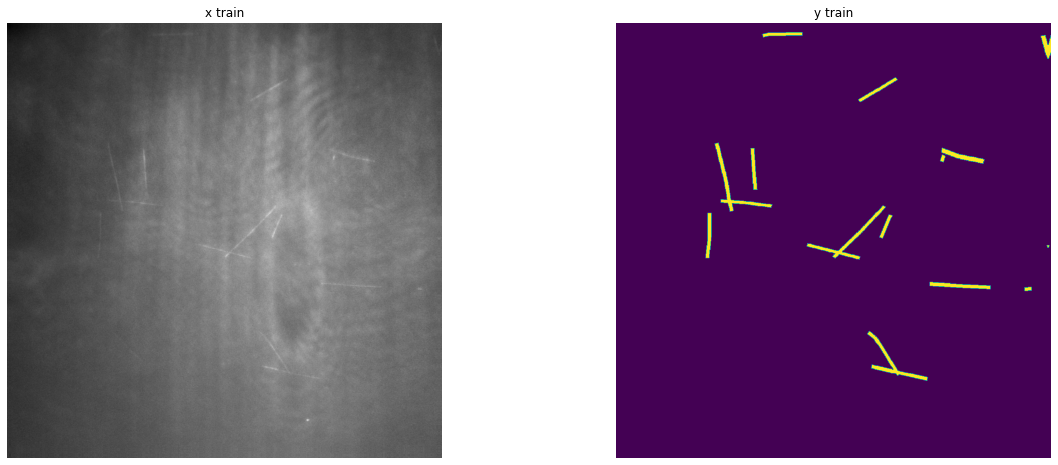

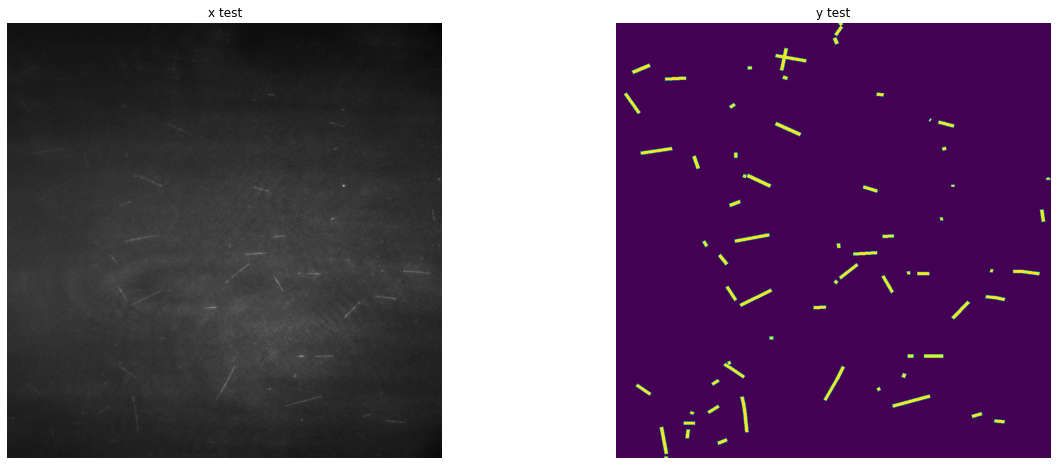

In [8]:
#Sanity check, view the quantities of data sets and visualize few images
imgsize1 = X.shape
print(imgsize1)
imgsize2 = Y.shape
print(imgsize2)
imgsize3 = X_test.shape
print(imgsize3)
imgsize4 = Y_test.shape
print(imgsize4)

# Select random image in training and validation dataset to visualize
import random
image_number = random.randint(0, len(X)-1)

fig, ax = plt.subplots(ncols=2, figsize=(20, 8))

ax[0].imshow(X[0])
ax[0].set_title('x train')
ax[0].axis('off')

y_train_squeeze = Y[0]
y_train_squeeze = y_train_squeeze[:,:,0]
ax[1].imshow(y_train_squeeze)
ax[1].set_title('y train')
ax[1].axis('off')

test_image_number = random.randint(0, len(X_test)-1)

fig, ax = plt.subplots(ncols=2, figsize=(20, 8))

ax[0].imshow(X_test[0])
ax[0].set_title('x test')
ax[0].axis('off')

y_test_squeeze = Y_test[0]
y_test_squeeze = y_test_squeeze[:,:,0]
ax[1].imshow(y_test_squeeze)
ax[1].set_title('y test')
ax[1].axis('off')

____________
stage3_unit4_conv1 (Conv2D)     (None, None, None, 2 589824      zero_padding2d_22[0][0]          
__________________________________________________________________________________________________
stage3_unit4_bn2 (BatchNormaliz (None, None, None, 2 1024        stage3_unit4_conv1[0][0]         
__________________________________________________________________________________________________
stage3_unit4_relu2 (Activation) (None, None, None, 2 0           stage3_unit4_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_23 (ZeroPadding2 (None, None, None, 2 0           stage3_unit4_relu2[0][0]         
__________________________________________________________________________________________________
stage3_unit4_conv2 (Conv2D)     (None, None, None, 2 589824      zero_padding2d_23[0][0]          
________________________________________________________________________________________________

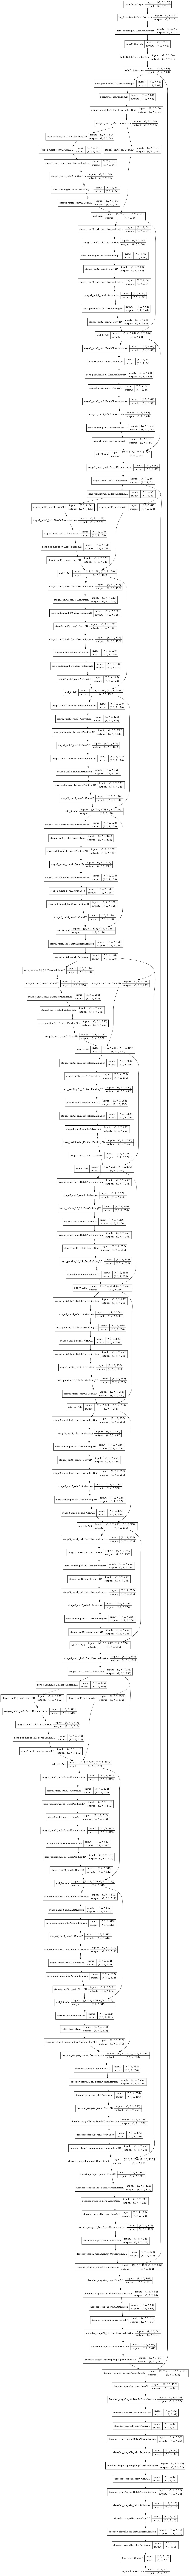

In [9]:
# Define and set up training model

# Model von Segmentation_Models
# Encoder
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# define optomizer
LR = 0.00002
optim = keras.optimizers.Adam(LR)

# Apply U-Net as network structure, set up the encoder weights, loss function and metrics
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(optimizer = optim, loss = sm.losses.bce_jaccard_loss, metrics = [sm.metrics.iou_score])

# View the model summary
print("The model architecture:\n")
print(model.summary())

# Visualize the neural network structure and save the image to folder "Semantic_Segmentation/model_output"
output_folder = "Semantic_Segmentation/model_output"
log_dir = os.path.join(output_folder,'logs_{}'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

tf.keras.utils.plot_model(model,to_file=os.path.join(log_dir,'model.png'),show_shapes=True,show_layer_names=True)

In [10]:
# Start Training

# Training Setting
# Set up ModelCheckPoints
checkpointer = tf.keras.callbacks.ModelCheckpoint('MT_1216_Semantic_Segmentation.h5', verbose = 1, save_best_only = True)

# Earlystop and Tensorboard can be added into callbacks if needed
callbacks = [#tf.keras.callbacks.EarlyStopping(patience = 6, monitor='val_iou_score'), 
             tf.keras.callbacks.TensorBoard(log_dir = './Semantic_Segmentation/logs')]

# Training input: 1200 images as training set and 300 images as validation set with image size 1216x1216 in RGB mode
# Tensor dimensions: 1216x1216x3 --- 608x608x64 --- 304x304x128 --- 152x152x256 --- 76x76x512 --- 38x38x1024 
history = model.fit(X, Y, 
                    batch_size = 2, 
                    #verbose = 1, 
                    epochs = 30, 
                    callbacks=callbacks,
                    validation_data=(X_test, Y_test)
                    #shuffle=False
                    )

# Save the model
model.save('./Semantic_Segmentation/MT_1216_Semantic_Segmentation.h5')

Epoch 1/30
756/756 [==============================] - 640s 846ms/step - loss: 1.3708 - iou_score: 0.0086 - val_loss: 1.2466 - val_iou_score: 0.0065
Epoch 2/30
756/756 [==============================] - 636s 841ms/step - loss: 1.1844 - iou_score: 0.0199 - val_loss: 1.1321 - val_iou_score: 0.0181
Epoch 3/30
756/756 [==============================] - 634s 838ms/step - loss: 1.0809 - iou_score: 0.0466 - val_loss: 1.0622 - val_iou_score: 0.0339
Epoch 4/30
756/756 [==============================] - 635s 840ms/step - loss: 1.0014 - iou_score: 0.0772 - val_loss: 1.0037 - val_iou_score: 0.0550
Epoch 5/30
756/756 [==============================] - 635s 841ms/step - loss: 0.9230 - iou_score: 0.1237 - val_loss: 0.9396 - val_iou_score: 0.0927
Epoch 6/30
756/756 [==============================] - 634s 838ms/step - loss: 0.8139 - iou_score: 0.2113 - val_loss: 0.8361 - val_iou_score: 0.1790
Epoch 7/30
756/756 [==============================] - 637s 843ms/step - loss: 0.6508 - iou_score: 0.3621 - val_l

In [11]:
# Evaluate the model
#test_labels = tf.keras.utils.normalize(test_labels)
# Evalutae the model by test set
#_, acc = model.evaluate(test_images, test_labels, batch_size = 2)
#print("Accuracy = ", (acc * 100.0), "%")

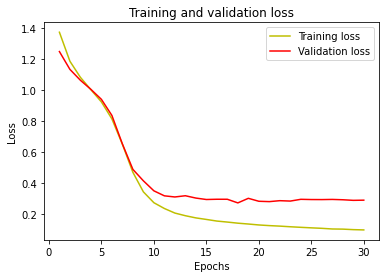

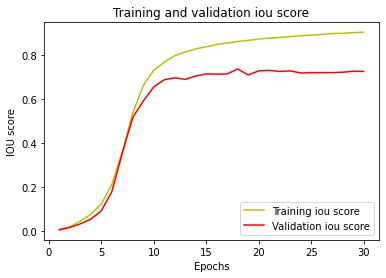

In [12]:
# Plot the training and validation losses at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("Semantic_Segmentation/loss.png")
plt.show()

# Plot the training and validation score at each epoch
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training iou score')
plt.plot(epochs, val_acc, 'r', label='Validation iou score')
plt.title('Training and validation iou score')
plt.xlabel('Epochs')
plt.ylabel('IOU score')
plt.legend()
plt.savefig("Semantic_Segmentation/iou_score.png")
plt.show()

In [13]:
#########################################################################################################################
# Threshold adjustment for better result if needed

#thre_model = keras.models.load_model("MT_1216_Semantic_Segmentation.h5", compile=False)
#y_pred = thre_model.predict(test_images)
#y_pred_thresholded = y_pred > 0.5
#intersection = np.logical_and(test_labels, y_pred_thresholded)
#union = np.logical_or(test_labels, y_pred_thresholded)
#iou_score = np.sum(intersection) / np.sum(union)
#print("IoU socre is: ", iou_score)

#########################################################################################################################

In [14]:
# Creat test/score images list
score_images = []

# Creat prediction of test/score images list
test_outputs = []

# Set the test set images and predictions saving path
testset_file = "Semantic_Segmentation/training_data/image_test"
predict_file = "Semantic_Segmentation/training_data/test_predict_output/"

# Get the names of test set images
test_img_name, test_read_path = delete_end_str(testset_file)

# Load the trained model
score_model = keras.models.load_model("Semantic_Segmentation/MT_1216_Semantic_Segmentation.h5", compile=False)

# Define a prediction process, with the input loading data are test set images and outputs are segmentation predictions
for directory_path in glob.glob(testset_file):
    
    # Check if the test set folder exist
    if os.path.exists(testset_file)==False:
        raise FileNotFoundError( 'No such file or directory:'+ testset_file)

    # Reading the images in the folder
    score_img_path = glob.glob(os.path.join(directory_path, '*.png'))

    # Make sure reading sequence of the images is correctly according to the name sequence of images
    score_img_path.sort()
    for l in score_img_path:
        
        # Read the images as RGB mode
        score_img = cv2.imread(l, cv2.IMREAD_COLOR)

        # Use reflect padding the images into size 1216x1216
        score_reflect_img = cv2.copyMakeBorder(score_img,8,8,8,8,cv2.BORDER_REFLECT)
        
        # Add up into score images list       
        score_images.append(score_reflect_img)

        # Convert list to array for machine learning processing
        score_reflect_img = np.array(score_reflect_img)

        # Expand the dimension of images for machine learning processing
        score_reflect_img = np.expand_dims(score_reflect_img, axis=0)

        # Use the trained model to predict segmentations
        score_prediction = score_model.predict(score_reflect_img)

        # Reshape the array into images
        score_prediction_image = score_prediction.reshape(1216, 1216)
        
        # Add up into prediction list
        test_outputs.append(score_prediction_image)

In [15]:
# Get the test images names
test_img_name, test_read_path = delete_end_str(testset_file)

# Create a name list
test_name_list = []

# Save the testing names into name list
for test_file_name in test_read_path:
  test_file_name = test_file_name.strip("Semantic_Segmentation/training_data/image_test/")
  test_name_list.append(test_file_name)

# Save the predictions into the test_output folder
for n in range(0, len(test_outputs)):
    test_prediction = test_outputs[n]

    # Change the names of prediction for recognition and further easy to load
    prediction_save_path = "%s/%s_prediction.png"% (predict_file, test_name_list[n])
    io.imsave(prediction_save_path, test_prediction)

/home/ben/anaconda3/envs/semantic_segmentation/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Semantic_Segmentation/training_data/test_predict_output//200818_xb_reaction2_6um009c1t001_prediction.png is a low contrast image
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/home/ben/anaconda3/envs/semantic_segmentation/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Semantic_Segmentation/training_data/test_predict_output//200818_xb_reaction2_6um009c1t030_prediction.png is a low contrast image
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/home/ben/anaconda3/envs/semantic_segmentation/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Semantic_Segmentation/training_data/test_predict_output//200818_xb_reaction2_6um009c1t060_prediction.png is a low contrast image
Lossy conversion from float32 to 